# Data Science 223 Project: Sentiment Analysis with BERT (Transformers)

In this project we will be using BERT (Bi-directional Encoder Representations transformer) to analyze bbc-text.csv



## **Imports**

In [ ]:
!pip install transformers datasets

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler, TrainingArguments, Trainer
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## **Data Import and Exploration**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('drive/MyDrive/bbc-text-1.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [ ]:
df['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [ ]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["category"])

labels = {'business':0,'entertainment':1,'politics':2,'sport':3,'tech':4}
df.head()

,category,text,label
0,tech,tv future in the hands of viewers with home th...,4
1,business,worldcom boss left books alone former worldc...,0
2,sport,tigers wary of farrell gamble leicester say ...,3
3,sport,yeading face newcastle in fa cup premiership s...,3
4,entertainment,ocean s twelve raids box office ocean s twelve...,1


In [ ]:
print(df['label'].value_counts())
print(df['category'].value_counts())

label
3    511
0    510
2    417
4    401
1    386
Name: count, dtype: int64
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


<Axes: xlabel='category', ylabel='count'>

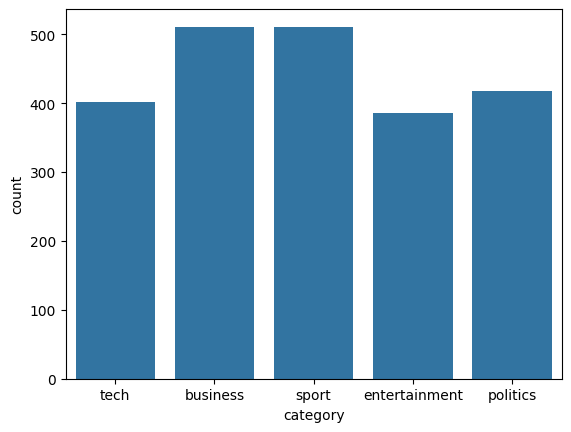

In [ ]:
sns.countplot(x='category', data=df)

## **Data Preparation**

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, stratify=df["label"]
)

train_labels = [int(label) for label in train_labels]
val_labels = [int(label) for label in val_labels]

train_texts = [str(text) for text in train_texts]
val_texts = [str(text) for text in val_texts]

train_dataset = Dataset.from_dict({
    "text": train_texts,
    "label": train_labels
})

val_dataset = Dataset.from_dict({
    "text": val_texts,
    "label": val_labels
})

In [ ]:
print(len(train_texts))
print(len(train_labels))

print(len(val_texts))
print(len(val_labels))

1780
1780
445
445


## **Initializing the Tokenizer, Model and Optimizer**

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
num_labels = len(set(train_labels))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

## **Function for model training**

For some reason the Trainer class isn't working as expected. So we define our own model_train function that handles validation after each epoch.

In [ ]:
def model_train(model, tokenizer, texts, labels, test_texts, test_labels, batch_size=1, epochs=3):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  all_losses = []
  all_accuracies = []

  model.eval()                                                                                        # Sets the model into Evaluation mode
  correct = 0
  total = 0
  with torch.no_grad():
      for i in tqdm(range(0, len(test_texts), batch_size), desc=f"Initial Validation"):
          batch_texts = test_texts[i:i+batch_size]
          batch_labels = test_labels[i:i+batch_size]

          encoding = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
          input_ids = encoding['input_ids'].to(device)
          attention_mask = encoding['attention_mask'].to(device)

          outputs = model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          predictions = torch.argmax(logits, dim=-1)

          batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long).to(device)
          correct += (predictions == batch_labels_tensor).sum().item()
          total += batch_labels_tensor.size(0)

  initial_accuracy = correct / total if total > 0 else 0
  print(f"Initial accuracy of the model on the test set: {initial_accuracy}")

  for epoch in range(epochs):
    print(f"Begin Training Epoch: {epoch + 1}/{epochs}")
    model.train()                                                                                       # Sets the model into Training mode
    epoch_losses = []

    for i in tqdm(range(0, len(train_texts), batch_size), desc=f"Epoch {epoch + 1} Training"):
        # Get batch texts and labels
        batch_texts = texts[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]

        # Tokenize batch
        encoding = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
        input_ids = encoding['input_ids'].to(model.device)
        attention_mask = encoding['attention_mask'].to(model.device)

        # Convert labels to tensor (long and shape [batch_size])
        batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long).to(model.device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(input_ids, attention_mask=attention_mask, labels=batch_labels_tensor)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        epoch_losses.append(batch_loss)

    all_losses.append(epoch_losses)
    avg_loss = sum(epoch_losses) / len(epoch_losses)

    model.eval()                                                                                        # Sets the model into Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(0, len(test_texts), batch_size), desc=f"Epoch {epoch + 1} Validation"):
            batch_texts = test_texts[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]

            encoding = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.long).to(device)
            correct += (predictions == batch_labels_tensor).sum().item()
            total += batch_labels_tensor.size(0)

    accuracy = correct / total if total > 0 else 0
    all_accuracies.append(accuracy)

    print(f"End of Epoch {epoch + 1}, Average Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}\n")

  return all_losses, all_accuracies

In [ ]:
all_losses, all_accuracies = model_train(model, tokenizer, train_texts, train_labels, val_texts, val_labels, batch_size=4, epochs=3)

Initial Validation: 100%|██████████| 112/112 [00:05<00:00, 18.98it/s]


Initial accuracy of the model on the test set: 0.19550561797752808
Begin Training Epoch: 1/3


Epoch 1 Validation: 100%|██████████| 112/112 [00:05<00:00, 19.08it/s]


End of Epoch 1, Average Loss: 0.4913, Test Accuracy: 0.9820

Begin Training Epoch: 2/3


Epoch 2 Validation: 100%|██████████| 112/112 [00:05<00:00, 19.05it/s]


End of Epoch 2, Average Loss: 0.0631, Test Accuracy: 0.9865

Begin Training Epoch: 3/3


Epoch 3 Validation: 100%|██████████| 112/112 [00:05<00:00, 19.03it/s]

End of Epoch 3, Average Loss: 0.0299, Test Accuracy: 0.9933

